#### Title: Classifying Red Wine Quality - Group 21

#### Introduction

"Vinho Verde'' is a Portuguese wine which has three main variants, of which we will be considering red. In the kaggle dataset we are using from UCI Machine Learning, its quality is affected by 11 different physicochemical variables, such as acidity, chlorides, density, etc.. These 11 variables determine the quality of the wine, on a scale from 0-10. For the purpose of the classification task - for which we will be using the K-nearest neighbors classification algorithm - we will be defining good quality wine as wine with a quality rating over 6.5, and anything below as poor quality. The good quality wines will be assigned 1 and the poor quality wines will be assigned 0. This is done for the purpose of making a binary classifier, which is faster  

Our goal is to use our data in order to classify the quality of various red wines at various price points that we have sourced from outside our dataset, ultimately to determine whether or not the differences in price reflect differences in quality. We can rephrase this as a predictive research question: What are the differences in physicochemical quality of various red wines at different price points? 

- State classification algorithm used
- Outline predictors chosen in intro
- suggestion: stat_summary() function in ggplot2 to calculate the mean or median quality score for each category and plot it on the histogram
- consider revising the research question (It is unclear whether the goal is to classify the quality of red wines based on three predictors or to determine whether price reflects differences in quality

#### Preliminary exploratory data analysis

In [1]:
library(dplyr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)
install.packages("themis")
library(themis)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [2]:
red_wine <- read_csv("data/winequality-red.csv")|>
    mutate(new_quality = ifelse(quality < 6.5, 0, 1)) |>
    mutate(new_quality = as_factor(new_quality))

colnames(red_wine) <- make.names(colnames(red_wine))
red_wine

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,new_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6,0
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5,0
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6,0


In [3]:
red_wine_split <- initial_split(red_wine, prop = 0.75, strata = new_quality)

red_wine_train <- training(red_wine_split)# |>
    #group_by(new_quality) |>
    #slice_sample(n = max(table(red_wine$new_quality)), replace = TRUE)

red_wine_test <- testing(red_wine_split)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8622168,10,0.006594072,Preprocessor1_Model01
2,accuracy,binary,0.8622168,10,0.006594072,Preprocessor1_Model02
3,accuracy,binary,0.8254302,10,0.010280669,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.7703450,10,0.01050690,Preprocessor1_Model08
9,accuracy,binary,0.7527886,10,0.01163836,Preprocessor1_Model09
10,accuracy,binary,0.7527886,10,0.01163836,Preprocessor1_Model10


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8852868
kap,binary,0.5297267


          Truth
Prediction   0   1
         0 321  21
         1  25  34

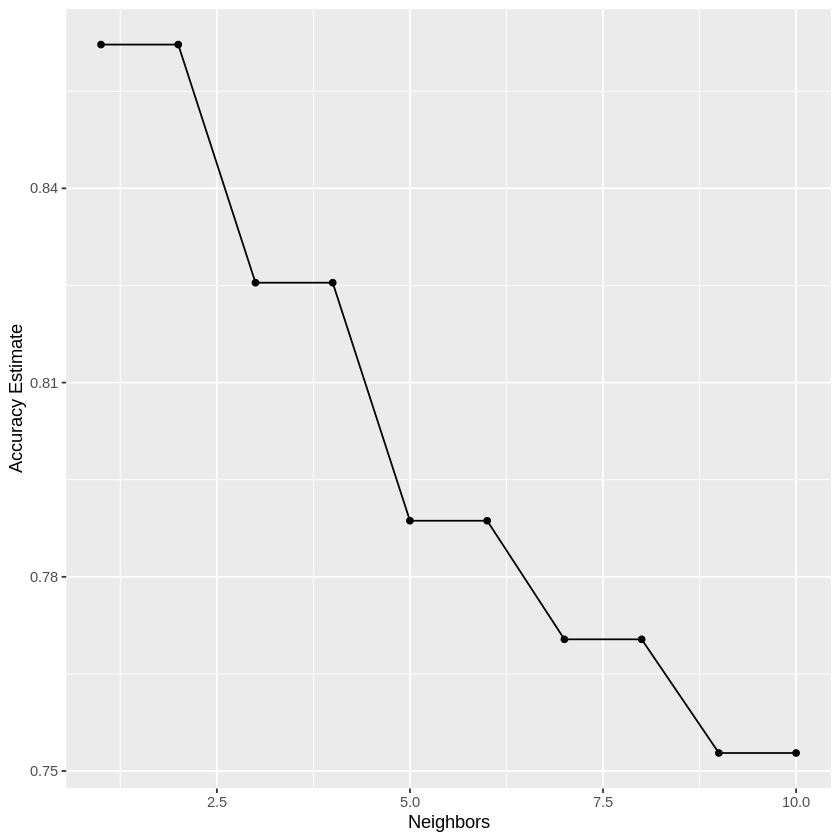

In [20]:
wine_recipe <- recipe(new_quality~ alcohol + pH + fixed.acidity, data = red_wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(new_quality, over_ratio = 1, skip = TRUE)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_vfold <- vfold_cv(red_wine_train, v = 10, strata = new_quality)

kvals <- tibble(neighbors = seq(1,10))

wine_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean))

accuracy_versus_k <- ggplot(wine_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

knn_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_2) |>
       fit(data = red_wine_train)

wine_test_predictions <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |>
       metrics(truth = new_quality, estimate = .pred_class) 

wine_mat <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |> 
       conf_mat(truth = new_quality, estimate = .pred_class)

wine_results
accuracy_versus_k
wine_test_predictions
wine_mat

In [ ]:
cheap_wine <- tibble(pH = 3.58,
                   fixed.acidity = 6.3,
                    alcohol = 13.9)

cheap_wine_2 <- tibble(pH = 3.77,
                   fixed.acidity = 5.3,
                    alcohol = 13.5)

cheap_wine_3 <- tibble(pH = 3.76,
                   fixed.acidity = 5.3,
                    alcohol = 14.5)

medium_wine <- tibble(pH = 3.7,
                   fixed.acidity = 7.07,
                    alcohol = 14.5)

exp_wine <- tibble(pH = 3.62,
                   fixed.acidity = 6.9,
                    alcohol = 13.5)

cheap_wine_predict <- predict(wine_fit, cheap_wine)
cheap_wine_2_predict <- predict(wine_fit, cheap_wine_2)
medium_wine_predict <- predict(wine_fit, medium_wine)
exp_wine_predict <- predict(wine_fit, exp_wine)
cheap_wine_3_predict <- predict(wine_fit, cheap_wine_3)

cheap_wine_predict
medium_wine_predict
exp_wine_predict
cheap_wine_2_predict
cheap_wine_3_predict

In [ ]:
red_wine_quality_count <- red_wine_train |>
    group_by(quality) |>
    summarize(count = n())

#missing_data <- red_wine_train |>
 #   summarize(NA_rows = sum(is.na(" ")))

red_wine_mean <- red_wine_train |>
    select(-quality) |>
    summarize(across(fixed.acidity:alcohol, mean))

red_wine_mean
red_wine_quality_count
#missing_data

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 12)
library(ggplot2)
library(GGally)

my_ggpairs <- ggpairs(red_wine_train, columns = c("fixed.acidity", "pH", "alcohol", "new_quality"))
my_ggpairs

In [ ]:
#Below, we have created three histograms according to three predictors, showing distribution of wine quality

options(repr.plot.height = 8, repr.plot.width = 8)
red_wine_plot <- red_wine_train |>
    ggplot(aes(x = pH, fill = quality)) + 
    geom_histogram() + 
    xlab("pH") +
    ylab("Count") +
    labs(fill = "Wine Quality") +
    ggtitle("Distribution of Qualities According to pH")

red_wine_plot2 <- red_wine_train |>
    ggplot(aes(x = fixed.acidity, fill = quality)) + 
    geom_histogram() + 
    xlab("Fixed Acidity (g/L)") +
    ylab("Count") +
    labs(fill = "Wine Quality") +
    ggtitle("Distribution of Qualities According to Fixed Acidity")

red_wine_plot3 <- red_wine_train |>
    ggplot(aes(x = alcohol, fill = quality)) + 
    geom_histogram() + 
    xlab("Alcohol (%)") +
    ylab("Count") +
    labs(fill = "Wine Quality") +
    ggtitle("Distribution of Qualities According to Alcohol Content")

red_wine_plot
red_wine_plot2
red_wine_plot3

#### Methods

We will conduct our data analysis using three predictors from our dataset: fixed acidity, alcohol content, and pH. We decided on these three predictors due to the online accessibility of this information; many red wine companies do not share the finer contents of their wines, such as sulfur dioxide, density, volatile and citric acids, etc. However alcohol content, fixed acidity, and pH are far more easily found and therefore the best predictors to answer our question.

To visualize our data, we have created three histograms, showing the distribution of wine quality according to each predictor. We have done this to focus on the effect of the predictors on the quality of wine. We will use this visualization to try and understand which specific amount of variable (alcohol content, pH, and fixed acidity) would correspond to a higher quality rating. These graphs hint at how the classifier we train will end up classifying wines as either higher or lower quality, and where the ranges of the predictors fall for higher quality wines.

- specify classification algorithm used
- More detailed explanation is required in how this visulization leads to better understand the relation between predictor vs target

#### Expected Outcomes & Significance

We expect to find the quality of wine based on the classifier we have created. Taking the Vinho Verde dataset, we will use our classifier to distinguish between the various wines in the sample based on three predictors, ranging from 0 to 10. 

If the classifier successfully identifies the quality of the red wine samples (related to their prices), separate from the data set, our classifier would demonstrate efficiency and accuracy that could be useful for data outside of ours. This can be a pioneering method in the wine industry that can be utilized commercially for pricing wine based on physical quality, or allow wine connoisseurs to assess wines digitally.

One question emerging from our results could be whether K-nearest neighbor classification could change the way the wine industry prices new wines. Should this classifier become a routine part of the industry, would it become a quicker way to distinguish between wine qualities and price them appropriately? Additionally, could current wine prices change?

- provide more detail on the expected outcomes and the potential significance of the findings
- acknowledge the limitations of the study and suggest potential avenues for future research